## Modelisation with UNET Mini

In [1]:
import sys  
sys.path.insert(0, './scripts')

# Import librairies, configs, helper functions
from helpers import *

config = base_config

# config["use_saved_model_path"] = "./model_a.keras"
config["mlwflow_experiment_title"] = "UNET Mini - Augmented"

n = NotebookProcessor(config)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


{
    "width": 512,
    "height": 256,
    "classes": 8,
    "use_augment": true,
    "image_per_augment": 1,
    "max_evals": 1,
    "mlwflow_tracking_uri": "http://127.0.0.1:5000",
    "mlwflow_experiment_title": "UNET Mini - Augmented",
    "train_sample_nb": 0,
    "val_sample_nb": 0,
    "use_saved_model_path": "",
    "gtFine_path": "./data/P8_Cityscapes_gtFine_trainvaltest.zip",
    "leftImg8bit_path": "./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip",
    "data_path": "./data/gtFine"
} 

Dataset already exist, skip downloading: ./data/P8_Cityscapes_gtFine_trainvaltest.zip
Dataset already exist, skip downloading: ./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip
- Using the full training dataset
- Using the full validation dataset


## Model definition

The model tested here is UNet minified (simplified by using half of the encoder/decoder).

> UNet features a contracting path on the left (encoder), which captures context by downsampling, and an expansive path on the right (decoder), which helps in precise localization by upsampling. In the middle, there is a bottleneck layer before the model transitions from downsampling to upsampling. Skip connections are used between corresponding layers in the contracting and expansive paths to help preserve spatial information lost during downsampling.

Here we start at 16 filters all the way to 32 and back to 16

This image represent UNet not minified.
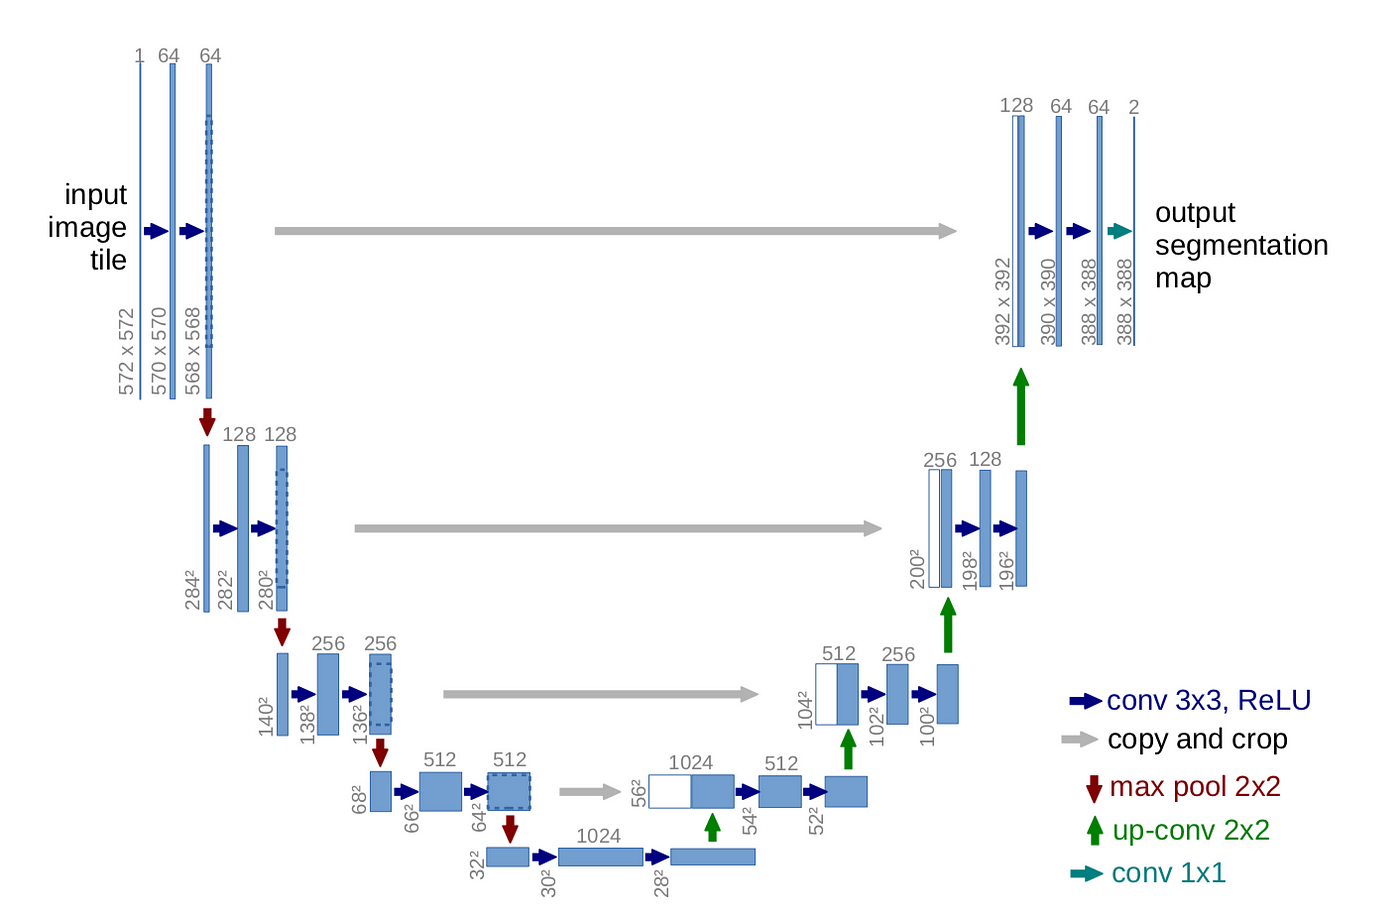

## Model creation

In [2]:

def conv_block(input_tensor, num_filters, dropout_rate=0.1):  
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_tensor)  
    x = BatchNormalization()(x)  # Adding batch normalization  
    x = Dropout(dropout_rate)(x)  
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)  
    x = BatchNormalization()(x)  # Adding batch normalization  
    return x  
  
def create_model(n_classes, img_width, img_height, img_channels):  
    inputs = Input((img_height, img_width, img_channels))  
  
    # Contraction path  
    c1 = conv_block(inputs, 16)  # Starting with fewer filters  
    p1 = MaxPooling2D((2, 2))(c1)  
      
    c2 = conv_block(p1, 32)  
    p2 = MaxPooling2D((2, 2))(c2)  
  
    c3 = conv_block(p2, 64)  # For mini U-Net, this could be considered as the bottleneck  
  
    # Expansive path   
    u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)  
    u4 = concatenate([u4, c2])  
    c4 = conv_block(u4, 32)  
       
    u5 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)  
    u5 = concatenate([u5, c1])  
    c5 = conv_block(u5, 16)  
       
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c5)  
       
    model = Model(inputs=[inputs], outputs=[outputs])  
    return model  

## Model Stats

### With augment

2024-03-01 14:54:57.183101: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-03-01 14:54:57.183122: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-03-01 14:54:57.183126: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-03-01 14:54:57.183160: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-01 14:54:57.183176: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


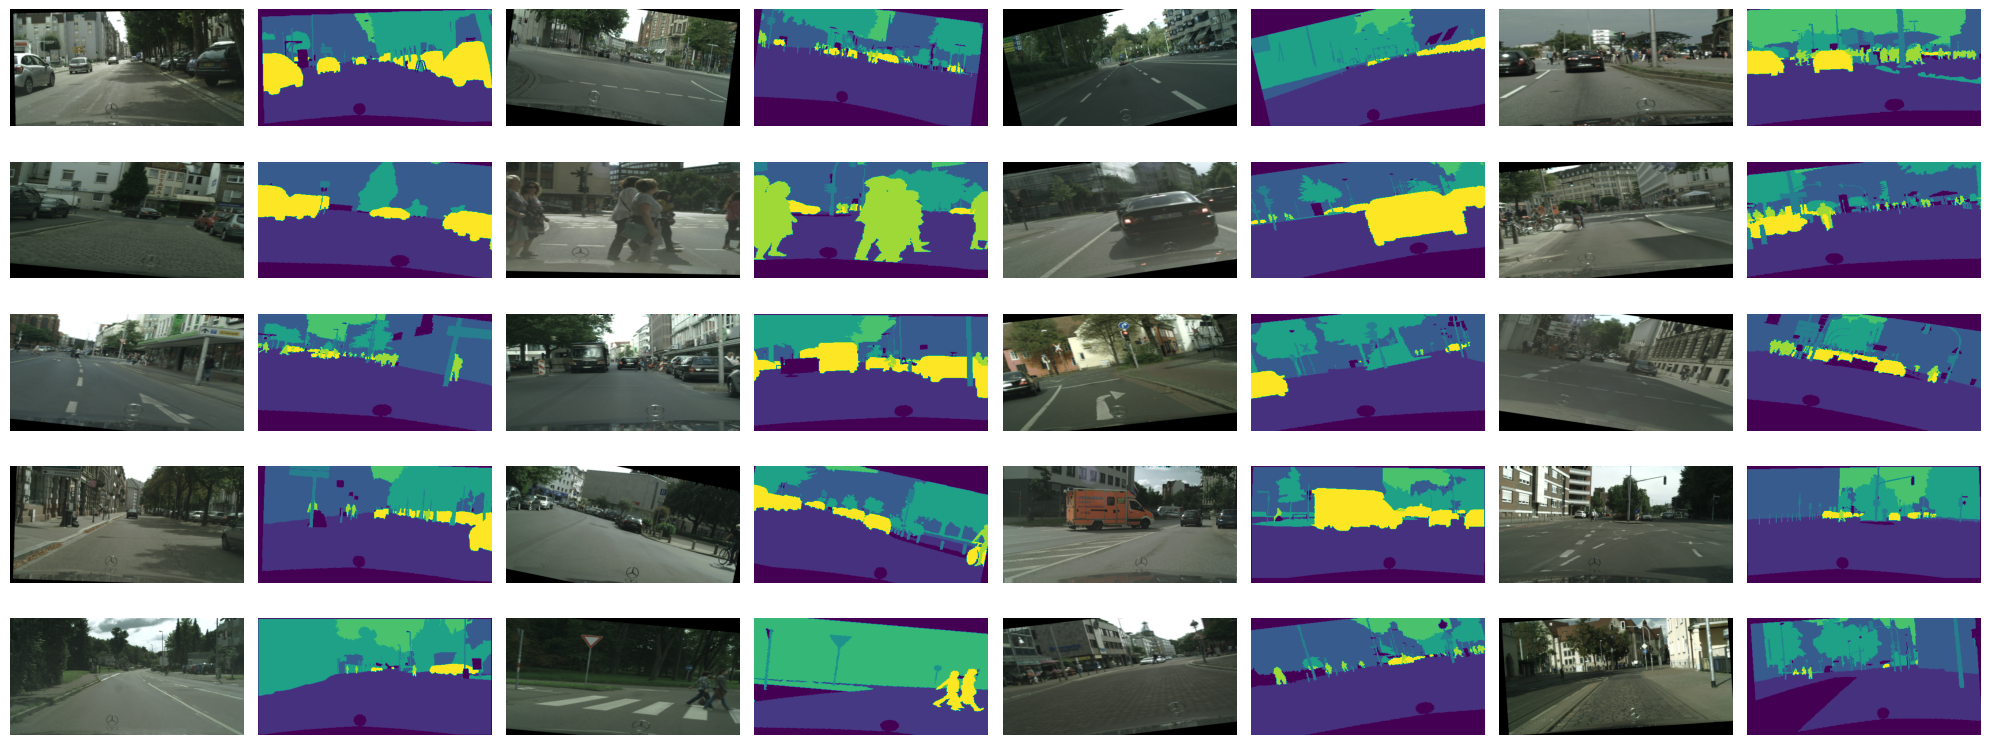

In [3]:
show_data_generator_images_sample(n)

In [4]:
model = create_model(n_classes=config["classes"], img_width=config["width"], img_height=config["height"], img_channels=3)
n.set_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 512, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 512, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 dropout (Dropout)           (None, 256, 512, 16)         0         ['batch_normalization[0][0

In [5]:
n.model_fit()

Epoch 1/12                                           

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

2024-03-01 14:55:03.451387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


991/991 [==============================] - 279s 281ms/step - loss: 0.7862 - dice_coef: 0.6411 - iou: 0.4813 - accuracy: 0.7547 - val_loss: 0.8377 - val_dice_coef: 0.6545 - val_iou: 0.4938 - val_accuracy: 0.7308

Epoch 2/12                                           

991/991 [==============================] - 278s 281ms/step - loss: 0.5840 - dice_coef: 0.7290 - iou: 0.5789 - accuracy: 0.8158 - val_loss: 0.8175 - val_dice_coef: 0.6447 - val_iou: 0.4847 - val_accuracy: 0.7311

Epoch 3/12                                           

991/991 [==============================] - 282s 285ms/step - loss: 0.5274 - dice_coef: 0.7548 - iou: 0.6114 - accuracy: 0.8340 - val_loss: 0.6766 - val_dice_coef: 0.7328 - val_iou: 0.5869 - val_accuracy: 0.7951

Epoch 4/12                                           

991/991 [==============================] - 301s 304ms/step - loss: 0.4999 - dice_coef: 0.7671 - iou: 0.6274 - accuracy: 0.8426 - val_loss: 0.7373 - val_dice_coef: 0.7121 - val_iou: 0.5641 - val_accur

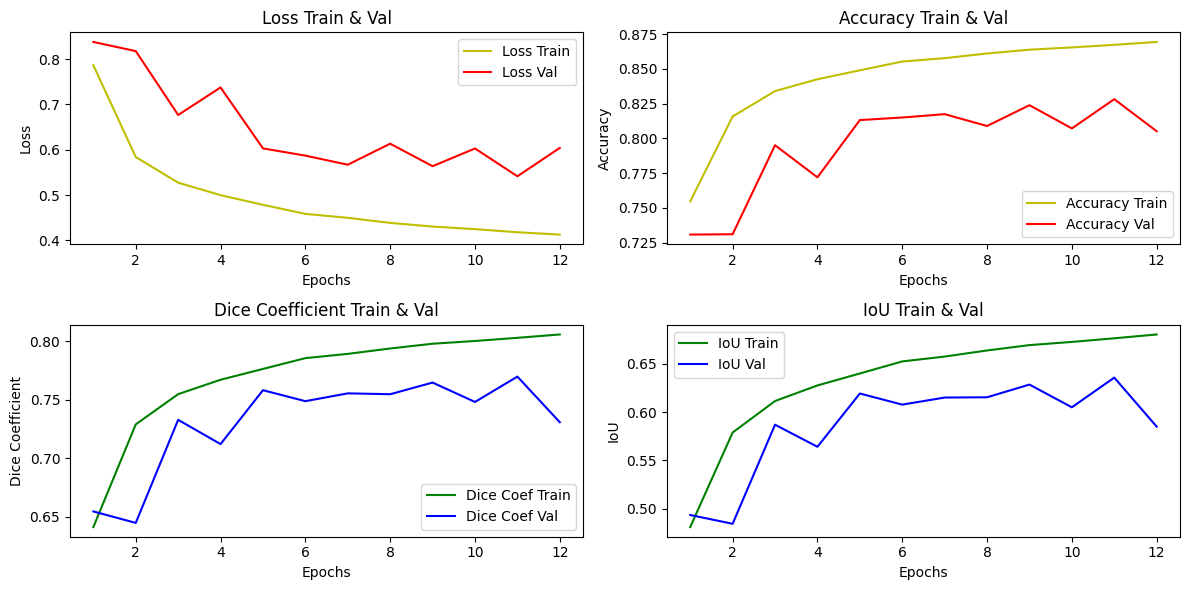

1/1 [==============================] - 0s 13ms/step


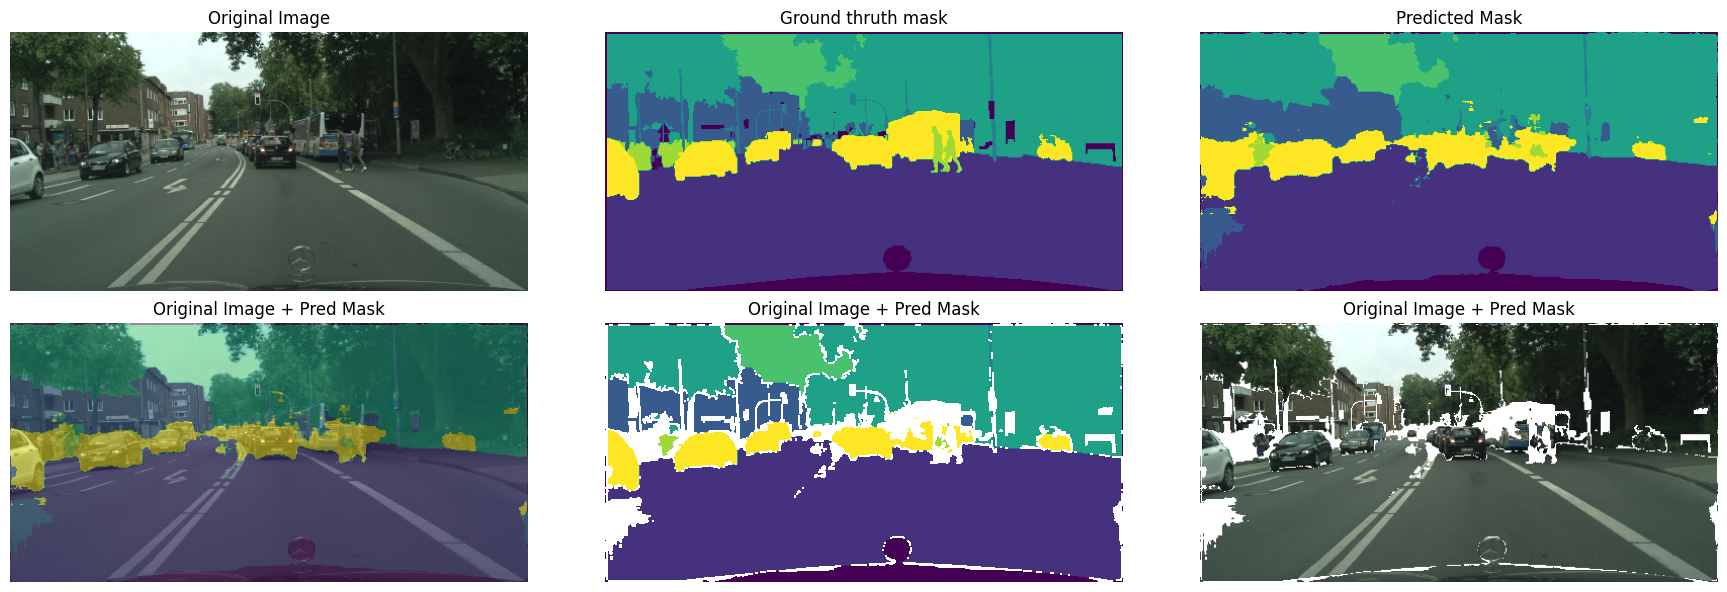

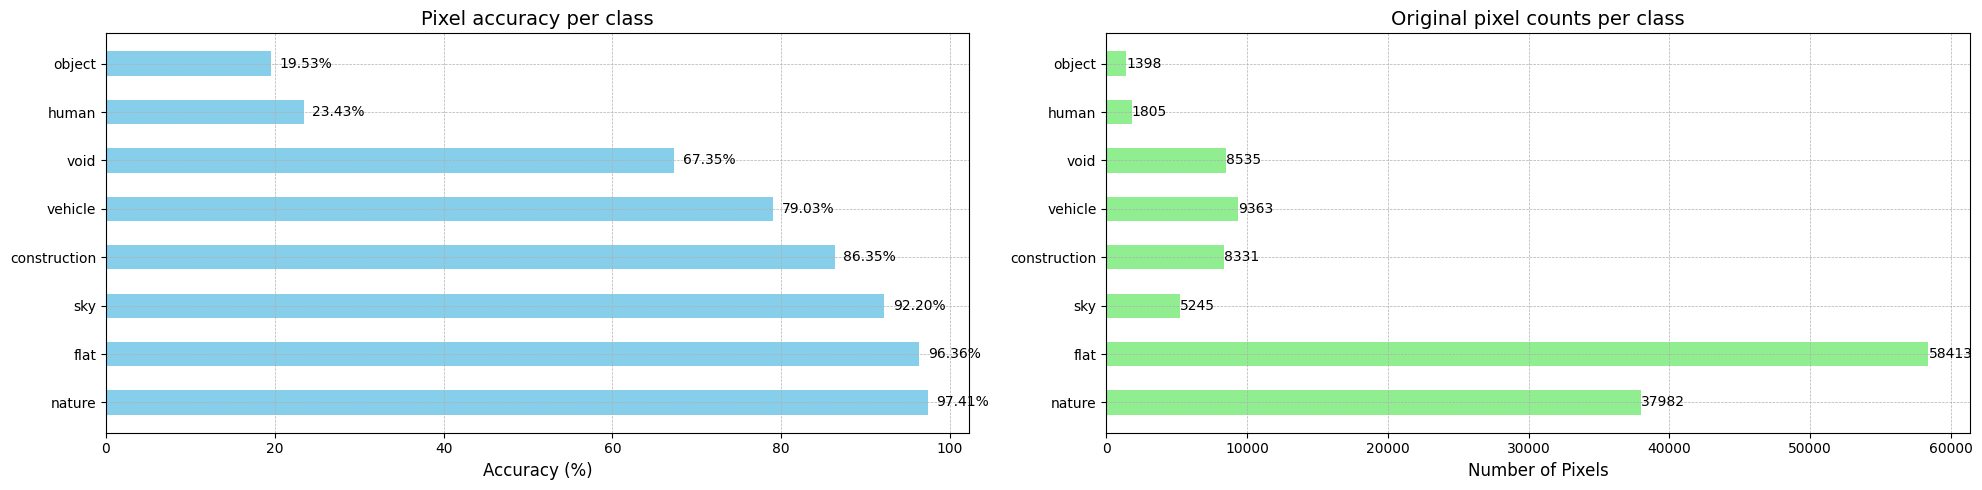

In [33]:
display_loss_accuracy_dice_iou(n.model_fit_history)
n.model_predict_with_display_and_accuracy(n.img["test"][0],n.mask["test"][0])

### Without augment

{
    "width": 512,
    "height": 256,
    "classes": 8,
    "use_augment": false,
    "image_per_augment": 1,
    "max_evals": 1,
    "mlwflow_tracking_uri": "http://127.0.0.1:5000",
    "mlwflow_experiment_title": "UNET Mini - Not Augmented",
    "train_sample_nb": 0,
    "val_sample_nb": 0,
    "use_saved_model_path": "",
    "gtFine_path": "./data/P8_Cityscapes_gtFine_trainvaltest.zip",
    "leftImg8bit_path": "./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip",
    "data_path": "./data/gtFine"
} 

Dataset already exist, skip downloading: ./data/P8_Cityscapes_gtFine_trainvaltest.zip
Dataset already exist, skip downloading: ./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip
- Using the full training dataset
- Using the full validation dataset


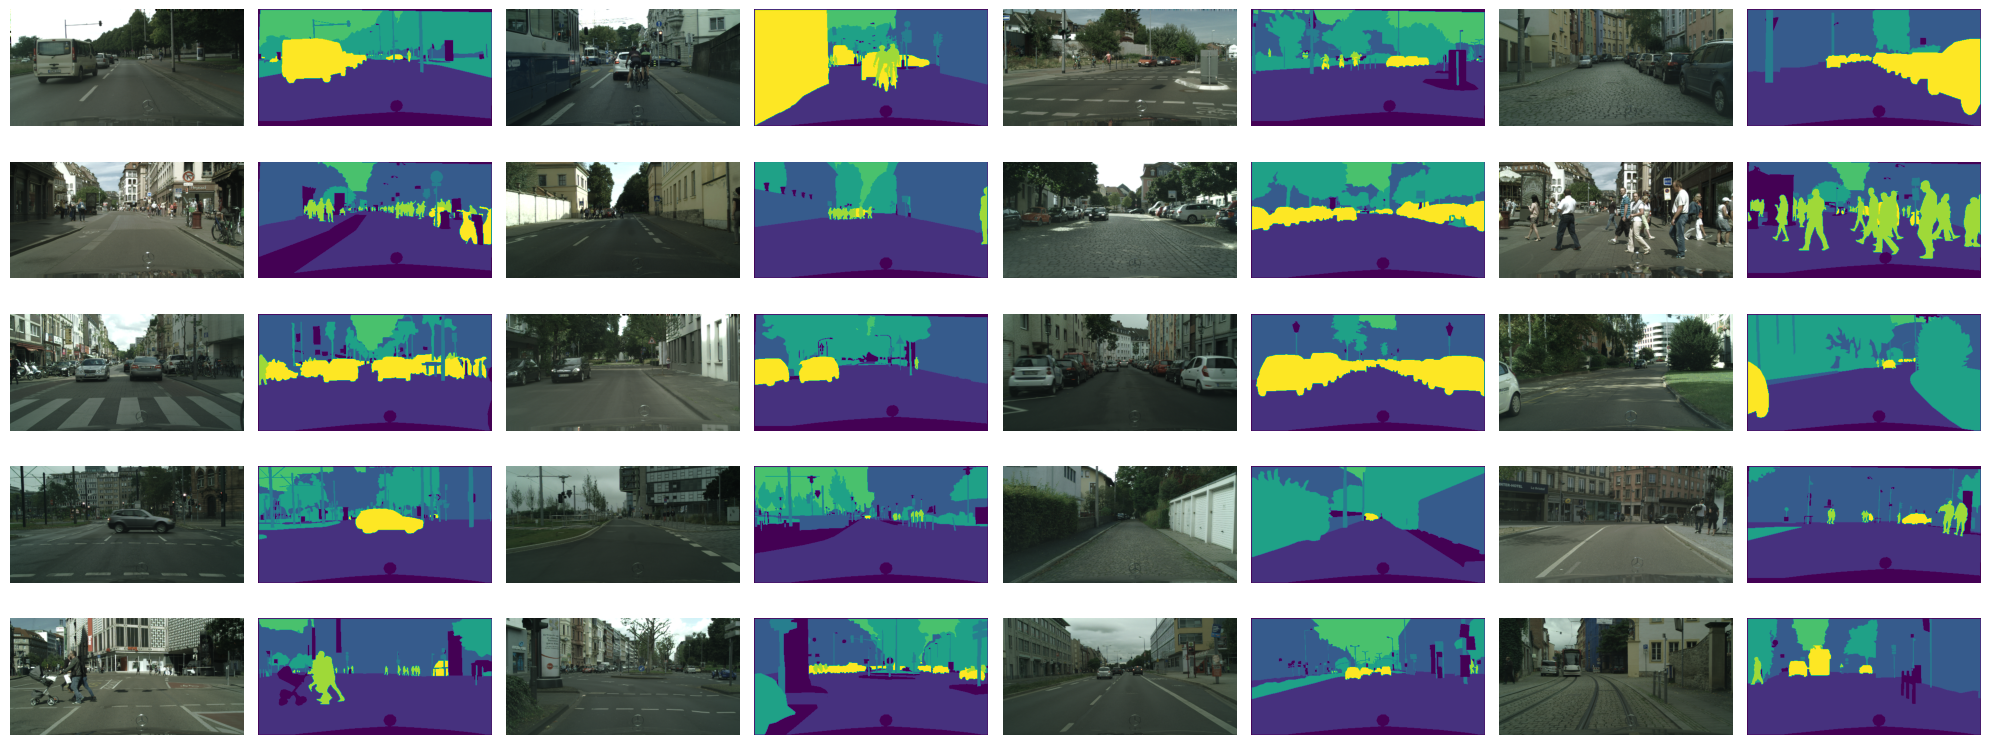

In [7]:
config_not_aug = {
    **config,
    "use_augment": False,
    "mlwflow_experiment_title":"UNET Mini - Not Augmented"

}

n_not_aug = NotebookProcessor(config_not_aug)
show_data_generator_images_sample(n_not_aug)

In [8]:
model_not_aug = create_model(n_classes=config["classes"], img_width=config["width"], img_height=config["height"], img_channels=3)
n_not_aug.set_model(model_not_aug)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 512, 3)]        0         []                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 256, 512, 16)         448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_10 (Ba  (None, 256, 512, 16)         64        ['conv2d_11[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 dropout_5 (Dropout)         (None, 256, 512, 16)         0         ['batch_normalization_10

In [9]:
n_not_aug.model_fit()

Epoch 1/12                                           

991/991 [==============================] - 292s 293ms/step - loss: 0.7845 - dice_coef: 0.6401 - iou: 0.4809 - accuracy: 0.7557 - val_loss: 1.0661 - val_dice_coef: 0.6248 - val_iou: 0.4651 - val_accuracy: 0.6841

Epoch 2/12                                           

991/991 [==============================] - 283s 286ms/step - loss: 0.5847 - dice_coef: 0.7272 - iou: 0.5766 - accuracy: 0.8149 - val_loss: 0.6954 - val_dice_coef: 0.7072 - val_iou: 0.5570 - val_accuracy: 0.7812

Epoch 3/12                                           

991/991 [==============================] - 278s 281ms/step - loss: 0.5328 - dice_coef: 0.7509 - iou: 0.6066 - accuracy: 0.8316 - val_loss: 0.6148 - val_dice_coef: 0.7316 - val_iou: 0.5853 - val_accuracy: 0.8040

Epoch 4/12                                           

991/991 [==============================] - 299s 301ms/step - loss: 0.4998 - dice_coef: 0.7655 - iou: 0.6254 - accuracy: 0.8415 - val_loss: 0.677

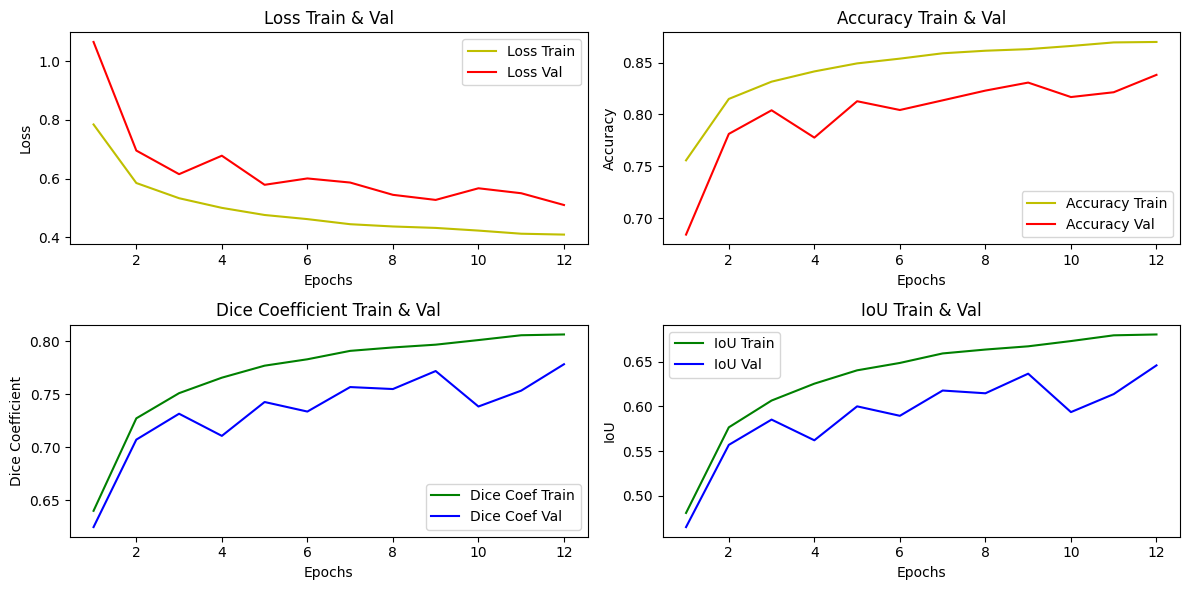

1/1 [==============================] - 0s 17ms/step


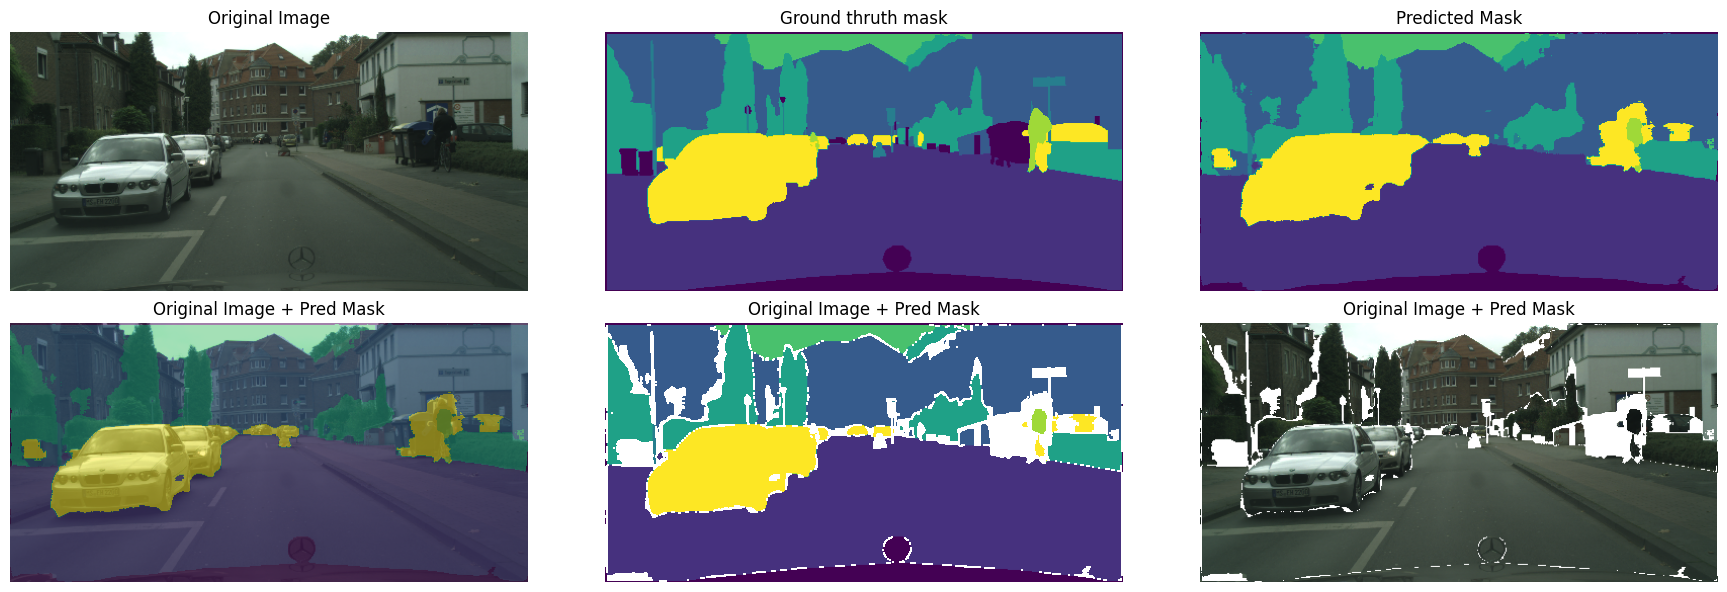

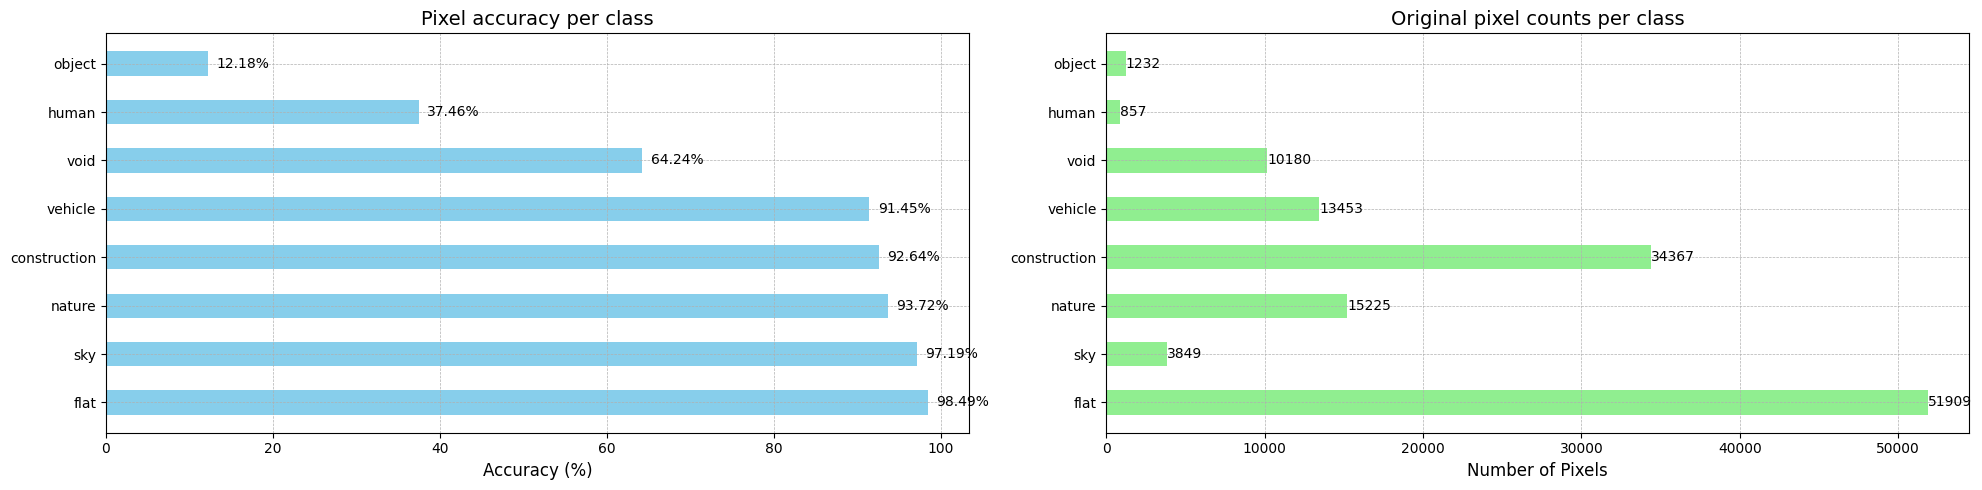

In [34]:
display_loss_accuracy_dice_iou(n_not_aug.model_fit_history)
n_not_aug.model_predict_with_display_and_accuracy(n_not_aug.img["test"][1],n_not_aug.mask["test"][1])

### Performance comparaison augmented vs not

58/58 [==============================] - 12s 203ms/step - loss: 0.3155 - dice_coef: 0.8436 - iou: 0.7332 - accuracy: 0.8977


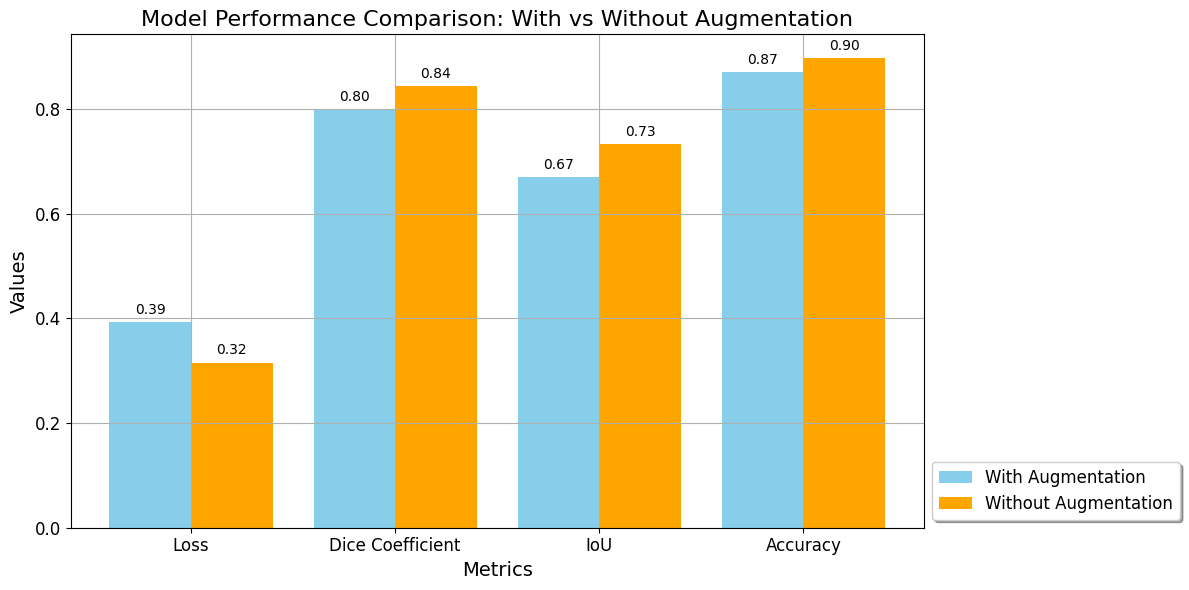

In [11]:
evaluate_with_and_without_aug(n, n_not_aug)

## Model Inference

1/1 [==============================] - 0s 16ms/step


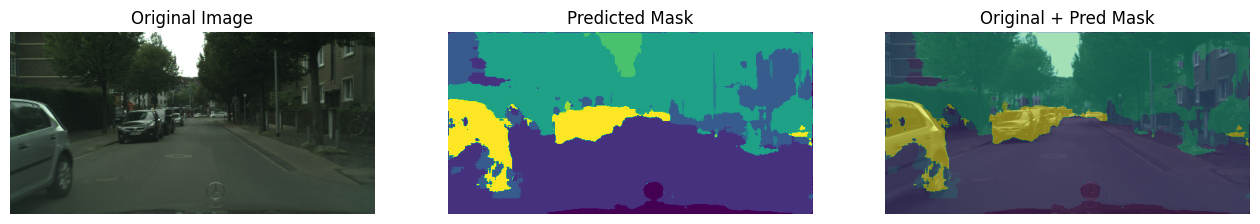

In [12]:
n.model_inference_with_display(n.img["test"][3])

1/1 [==============================] - 0s 27ms/step


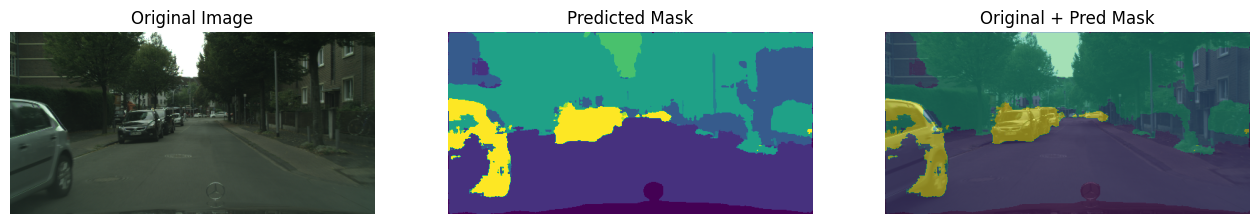

In [13]:
n_not_aug.model_inference_with_display(n_not_aug.img["test"][3])